In [12]:
#Installs
# !pip install surprise

In [13]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import base64
from collections import defaultdict
import surprise as sp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [14]:
#reconfigure default plot settings
pd.set_option('display.max_columns', 10)
sns.set_palette(sns.color_palette("crest", 8))
matplotlib.rc('figure', figsize = (12, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

In [15]:
#Turn the CSV files into data frames
books = pd.read_csv('../data/processed/books.csv')
ratings = pd.read_csv('../data//raw//ratings.csv')

In [16]:
# Make a sparce matrix

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        book_mapper: dict that maps movie id's to movie indices
        book_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['user_id'].nunique()
    M = df['book_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    book_mapper = dict(zip(np.unique(df["book_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    book_inv_mapper = dict(zip(list(range(M)), np.unique(df["book_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    book_index = [book_mapper[i] for i in df['book_id']]

    X = csr_matrix((df["rating"], (book_index, user_index)), shape=(M, N))
    
    return X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper

In [17]:
X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper = create_X(ratings)

In [18]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.12%


In [19]:
# Top 20 raters by id
ratings.user_id.value_counts(ascending=False)[:20]

12874    200
30944    200
52036    199
12381    199
28158    199
45554    197
6630     197
37834    196
15604    196
7563     196
14372    196
19729    196
9806     196
9668     196
24143    196
10509    195
33065    195
25840    195
9731     195
38798    195
Name: user_id, dtype: int64

In [20]:
# Bottom 20 raters by id
ratings.user_id.value_counts(ascending=True)[:20]

34590    19
43675    20
40753    21
32128    21
51725    21
42736    22
25258    22
38280    22
16470    22
37640    22
50918    22
32960    22
34099    22
40299    22
22020    22
43672    22
25856    22
48077    22
39865    23
18327    23
Name: user_id, dtype: int64

In [21]:
num_ratings = ratings.user_id.value_counts()

In [22]:
hundred_fifty_ids = num_ratings[num_ratings.values > 150].index

In [23]:
hundred_fifty = ratings[ratings.user_id.isin(hundred_fifty_ids)]

In [25]:
hundred_fifty

,user_id,book_id,rating
977,75,3254,2
978,75,6777,5
979,75,11,5
981,75,372,4
982,75,476,3
...,...,...,...
5976353,50480,1688,3
5976354,50480,2216,4
5976355,50480,1539,3
5976356,50480,2772,4


In [39]:
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [26]:
def read_data_surprise (df, minstar=1, maxstar=3, col1='user_id', col2='route', col3='rating'):
    '''
    Produces a surpise library data object from original dataframe

    ---Parameters---

    df (Pandas DataFrame)
    minstar (int) minimum star possible in dataset (default set to 1)
    maxstar (int) maximum star possible in dataset (default set to 3)
    col1 (string) column name that MUST correspond the the users in the df
    col2 (string) column name that MUST corresponds the the items in the df
    col3 (string) column name that corresponds the the ratings of the items in the df

    ---Returns---
    surprise library data object to manipulate later

    '''
    # need to specify the rating_scale of stars (default 1-3 stars)
    reader = sp.Reader(rating_scale=(minstar, maxstar))
    # The columns must correspond to user id, item id and ratings (in that order).
    data = sp.Dataset.load_from_df(df[[col1, col2, col3]], reader)

    return data


In [27]:
reader = sp.Reader(rating_scale=(1, 5))
surprise_150_data = sp.Dataset.load_from_df(hundred_fifty[['user_id','book_id','rating']], reader)

In [44]:
hundred_ids = num_ratings[num_ratings.values > 100].index
hundred = ratings[ratings.user_id.isin(hundred_ids)]
surprise_100_data = sp.Dataset.load_from_df(hundred[['user_id','book_id','rating']], reader)

In [45]:
reader = sp.Reader(rating_scale=(1, 5))
surprise_data = sp.Dataset.load_from_df(ratings[['user_id','book_id','rating']], reader)

In [36]:
#Violin plot of violin_accuracy

def violin_accuracy(algo, testset):
    '''
    Plot violin chart showing descrepancy between true and predicted ratings with means & standard deviations included

    ---Parameters---
    algo (predefined variable) of the algorithm being used
    testset (variable) of which test data set being used

    ---Returns---
    Means and standard deviations of the estimated predictions per true rating
    Violin chart comparing real ratings to predicted ratings

    '''

    predictions = algo.test(testset)
    predict_df = pd.DataFrame(predictions)

    #Calculating Means and standard deviations per true rating
    p_mean= predict_df.groupby("r_ui")["est"].mean()
    p_std = predict_df.groupby("r_ui")["est"].std()
    print (type(p_mean))
    print (f"Means of Predicted per True Rating: {p_mean}")
    print (f"STD of Predicted per True Rating: {p_std}")

    #Plotting the Violin plot
    sns.violinplot( x=predict_df["r_ui"], y= predict_df["est"], saturation= .5)
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('True vs. Predicted Ratings Using SVD')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8487
<class 'pandas.core.series.Series'>
Means of Predicted per True Rating: r_ui
1.0    3.206717
2.0    3.357571
3.0    3.586502
4.0    3.866880
5.0    4.242924
Name: est, dtype: float64
STD of Predicted per True Rating: r_ui
1.0    0.696751
2.0    0.519859
3.0    0.450896
4.0    0.427026
5.0    0.468791
Name: est, dtype: float64


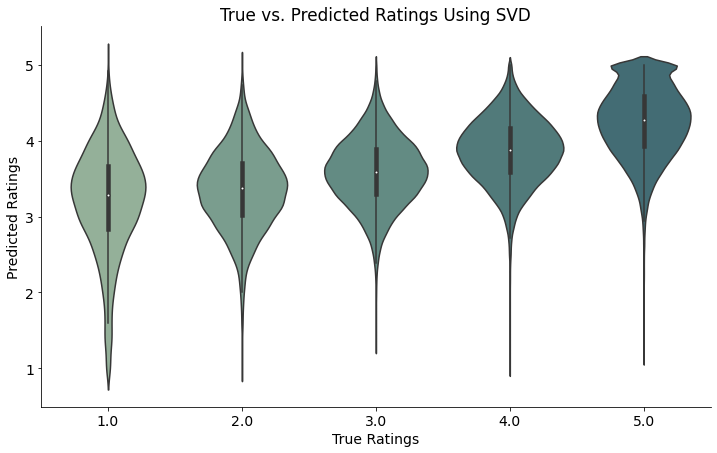

In [37]:
trainset2, testset2 = train_test_split(surprise_150_data, test_size=.2)
algo = sp.KNNBaseline()
algo.fit(trainset2)
predictions2 = algo.test(testset2)
sp.accuracy.rmse(predictions2)
violin_accuracy(algo, testset2)

In [46]:
hundred_ids = num_ratings[num_ratings.values > 100].index
hundred = ratings[ratings.user_id.isin(hundred_ids)]
surprise_100_data = sp.Dataset.load_from_df(hundred[['user_id','book_id','rating']], reader)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8422
<class 'pandas.core.series.Series'>
Means of Predicted per True Rating: r_ui
1.0    3.328582
2.0    3.430918
3.0    3.616640
4.0    3.885248
5.0    4.260179
Name: est, dtype: float64
STD of Predicted per True Rating: r_ui
1.0    0.652801
2.0    0.501992
3.0    0.442585
4.0    0.413249
5.0    0.456126
Name: est, dtype: float64


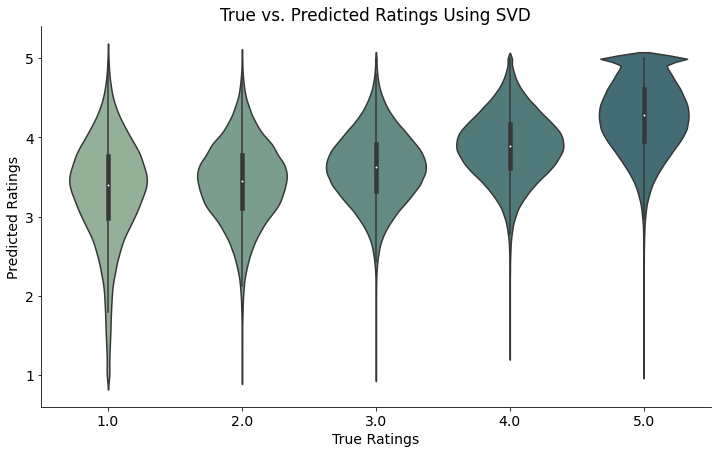

In [47]:
trainset2, testset2 = train_test_split(surprise_100_data, test_size=.2)
algo = sp.KNNBaseline()
algo.fit(trainset2)
predictions2 = algo.test(testset2)
sp.accuracy.rmse(predictions2)
violin_accuracy(algo, testset2)

In [ ]:
reader = sp.Reader(rating_scale=(1, 5))
surprise_data = sp.Dataset.load_from_df(ratings[['user_id','book_id','rating']], reader)

In [ ]:
fifty_ids = num_ratings[num_ratings.values > 50].index
fifty = ratings[ratings.user_id.isin(fifty_ids)]
surprise_100_data = sp.Dataset.load_from_df(fifty[['user_id','book_id','rating']], reader)

In [ ]:
reader = sp.Reader(rating_scale=(1, 5))
surprise_data = sp.Dataset.load_from_df(ratings[['user_id','book_id','rating']], reader)